# Object Detection for Autonomous Vehicles

### Using IPEX and oneDNN for GPU inference and training

#### Cheking GPU Access

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/home/u196035/SneakyTurtle


### Installing Libraries

In [2]:
!pip install -q -i https://test.pypi.org/simple/ supervision==0.3.0 && echo FINISHED1
!pip install -q transformers && echo FINISHED2
!pip install -q pytorch-lightning && echo FINISHED3
!pip install -q roboflow && echo FINISHED4
!pip install -q timm && echo FINISHED5
!pip install -q opencv-python && echo FINISHED6
!pip install -q tqdm
!pip install --upgrade tqdm

FINISHED1
FINISHED2
FINISHED3
FINISHED4
FINISHED5
FINISHED6


In [5]:
!pip install -q roboflow==0.2.34
# from roboflow.utils import tqdm

### Importing packages

In [7]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision as sv
import transformers
import pytorch_lightning

print(
    "roboflow:", roboflow.__version__, 
    "; supervision:", sv.__version__, 
    "; transformers:", transformers.__version__, 
    "; pytorch_lightning:", pytorch_lightning.__version__
)

/bin/bash: nvcc: command not found
torch:  2.0 ; cuda:  cu117
roboflow: 0.2.34 ; supervision: 0.3.0 ; transformers: 4.30.2 ; pytorch_lightning: 2.0.4


In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [9]:
# set the device to cpu
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

### Downloading the dataset
#### The annotated and preprocessed dataset is downloaded from Roboflow using the Roboflow API

## Detection Transformer (DETR)
Loading DETR for the model

In [10]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor

# DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT, ignore_mismatched_sizes  = True )
model = DetrForObjectDetection.from_pretrained(CHECKPOINT, ignore_mismatched_sizes  = True)
model

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

## Creating COCO data loaders
The loaders will be used to load different sets of the dataset

In [11]:
import os
import torchvision
import random

# settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
location = "/home/u196035/SneakyTurtle/datasets/Self-Driving-Car-oneAPI-3"
TRAIN_DIRECTORY = os.path.join(location, "train")
VAL_DIRECTORY = os.path.join(location, "valid")
TEST_DIRECTORY = os.path.join(location, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

# Reduce dataset size by 75%
TRAIN_SIZE_REDUCTION = 0.5
VAL_SIZE_REDUCTION = 0.5
TEST_SIZE_REDUCTION = 0.5

# Get reduced dataset sizes
train_size = int(len(TRAIN_DATASET) * TRAIN_SIZE_REDUCTION)
val_size = int(len(VAL_DATASET) * VAL_SIZE_REDUCTION)
test_size = int(len(TEST_DATASET) * TEST_SIZE_REDUCTION)

# Get indices of the datasets
train_indices = list(range(len(TRAIN_DATASET)))
val_indices = list(range(len(VAL_DATASET)))
test_indices = list(range(len(TEST_DATASET)))

# Shuffle indices
random.shuffle(train_indices)
random.shuffle(val_indices)
random.shuffle(test_indices)

# Select reduced samples
TRAIN_DATASET = torch.utils.data.Subset(TRAIN_DATASET, train_indices[:train_size])
VAL_DATASET = torch.utils.data.Subset(VAL_DATASET, val_indices[:val_size])
TEST_DATASET = torch.utils.data.Subset(TEST_DATASET, test_indices[:test_size])

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))


loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
Number of training examples: 6054
Number of validation examples: 788
Number of test examples: 586


## Visualize data entry

Image #5311


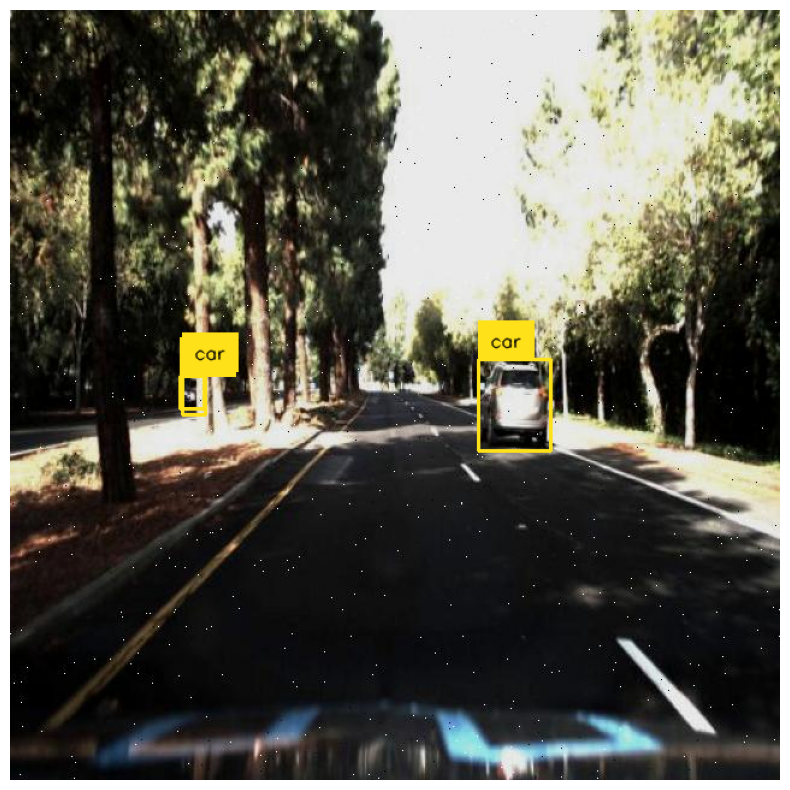

In [12]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Select random image
image_ids = TRAIN_DATASET.dataset.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# Load image and annotations
image_info = TRAIN_DATASET.dataset.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.dataset.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.dataset.root, image_info['file_name'])
image = cv2.imread(image_path)

# Annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# Extract labels
categories = TRAIN_DATASET.dataset.coco.cats
id2label = {k: v['name'] for k, v in categories.items()}

labels = [
    f"{id2label[detection[2]]}"
    for detection in detections
    if detection[2] is not None
]

box_annotator = sv.BoxAnnotator()
annotated_image = box_annotator.annotate(scene=image, detections=detections, labels=labels)

# Display annotated image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [13]:
categories

{0: {'id': 0,
  'name': 'cars-trafficlights-pedestrian-',
  'supercategory': 'none'},
 1: {'id': 1,
  'name': 'biker',
  'supercategory': 'cars-trafficlights-pedestrian-'},
 2: {'id': 2,
  'name': 'car',
  'supercategory': 'cars-trafficlights-pedestrian-'},
 3: {'id': 3,
  'name': 'pedestrian',
  'supercategory': 'cars-trafficlights-pedestrian-'},
 4: {'id': 4,
  'name': 'trafficLight',
  'supercategory': 'cars-trafficlights-pedestrian-'},
 5: {'id': 5,
  'name': 'trafficLight-Green',
  'supercategory': 'cars-trafficlights-pedestrian-'},
 6: {'id': 6,
  'name': 'trafficLight-GreenLeft',
  'supercategory': 'cars-trafficlights-pedestrian-'},
 7: {'id': 7,
  'name': 'trafficLight-Red',
  'supercategory': 'cars-trafficlights-pedestrian-'},
 8: {'id': 8,
  'name': 'trafficLight-RedLeft',
  'supercategory': 'cars-trafficlights-pedestrian-'},
 9: {'id': 9,
  'name': 'trafficLight-Yellow',
  'supercategory': 'cars-trafficlights-pedestrian-'},
 10: {'id': 10,
  'name': 'trafficLight-YellowLeft'

In [14]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

## Train model with PyTorch Lightning

In [15]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT, 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

## Optimization code
### Installing required packages to enable IPEX and oneDNN optimizations

In [16]:
!pip install intel-extension-for-pytorch

Defaulting to user installation because normal site-packages is not writeable


### Importing libraries to use IPEX and oneDNN functionalities 

In [ ]:
import intel_extension_for_pytorch as ipex
import torch.optim as optim

model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
model = model.to(device)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

### Enabling IPEX optimizations and auto-mixed precision with BF16 for GPU inference
#### This step registers IPEX optimizations, enables auto-mixed precision with BF16 data type, and moves the model to the IPEX device for GPU inference

In [19]:
# Create a placeholder optimizer for inference mode optimization
optimizer = optim.SGD(model.parameters(), lr=0.001)

model, _ = ipex.optimize(model, optimizer=optimizer, dtype=torch.bfloat16)
# model, optimizer = ipex.optimize(model, optimizer=optimizer)

from pytorch_lightning import Trainer
import time

%cd {HOME}

MAX_EPOCHS = 1

trainer = Trainer(accelerator="cpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

start_time = time.time()

trainer.fit(model)

end_time = time.time()
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

2023-06-26 14:51:28,984 - timm.models._builder - INFO - Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
2023-06-26 14:51:29,076 - timm.models._hub - INFO - [timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([13, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/home/u196035/SneakyTurtle


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.6 M
-------------------------------------------------
41.4 M    Trainable params
222 K     Non-trainable params
41.6 M    Total params
166.589   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Training time: 5892.856446266174 seconds


**Training time:  98min**

In [20]:
outputs.logits.shape

torch.Size([4, 100, 13])

## Neural Compressor

In [ ]:
!pip install -q neural-compressor

In [ ]:
import neural_compressor

In [ ]:
from neural_compressor.quantization import fit
from neural_compressor.config import PostTrainingQuantConfig, TuningCriterion, AccuracyCriterion

In [ ]:
config = PostTrainingQuantConfig(approach = "dynamic")
q_model = quantization.fit(model, config)

In [ ]:
q_model.save('./output')

In [ ]:
from neural_compressor.utils.pytorch import load
int8_model = load('./output', model)

### Saving the model
#### The saved model will be useful during deployment

In [29]:
torch.save(model.state_dict(), "modelopt.pth")

In [ ]:
model

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): _IPEXConv2d()
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): _IPEXConv2d()
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): _IPEXConv2d()
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): _IPEXConv2d()
                (bn3): DetrFrozenBatchNorm2d()
                (act3): ReLU(inplace=True)
                (downsample): Sequential(
                  (0): _IPEXConv2d()
      

## Inference on test dataset
#### Prediction on a sample test dataset in order to check how well the model predicts

Image #753
ground truth


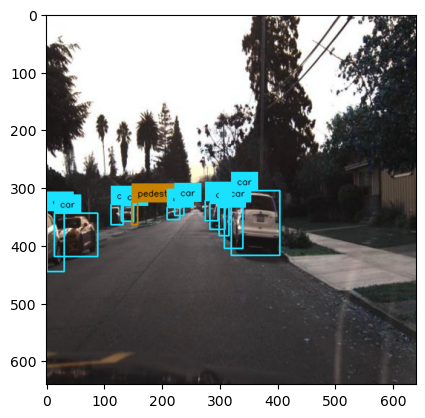

detections


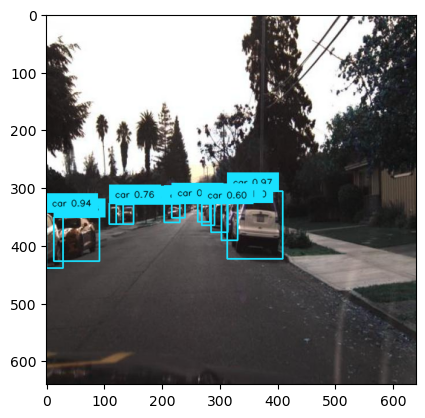

In [ ]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt


# utils
categories = TEST_DATASET.dataset.coco.cats
id2label = {k: v['name'] for k, v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.dataset.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TEST_DATASET.dataset.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.dataset.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.dataset.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('ground truth')
plt.imshow(frame)
plt.show()

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt')
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]])
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_TRESHOLD, 
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
plt.imshow(frame)
plt.show()


## Evaluation on test dataset
**Evaluation Metric**: IOU Score , mAP

In [ ]:
!pip install -q coco_eval

#### Helper functions for evaluation

In [ ]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [ ]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

evaluator = CocoEvaluator(coco_gt=TEST_DATASET.dataset.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/147 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.134
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.044
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.046
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

### Result Analysis
#### Model trained on low eopchs: Satisfactory IOU score.